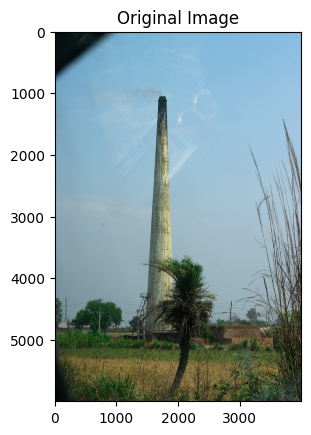

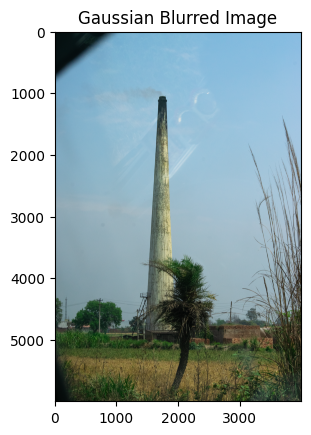

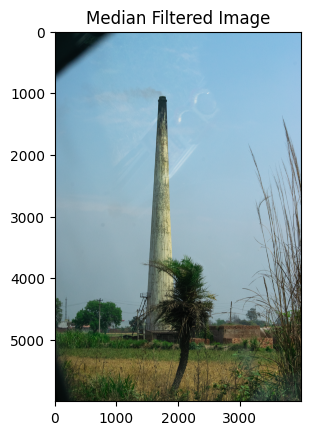

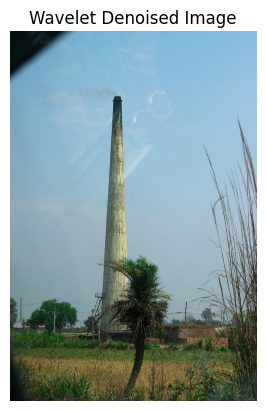

Gaussian Blur:
PSNR: 31.93, SSIM: 0.9435, MSE: 0.000641

Median Filter:
PSNR: 29.97, SSIM: 0.9174, MSE: 0.001006

Wavelet Denoising:
PSNR: 59.59, SSIM: 0.9999, MSE: 0.000001



In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

import cv2
from skimage import io, restoration, metrics
from matplotlib import pyplot as plt

def load_image(path):
    image = io.imread(path)
    image = image.astype('float32') / 255.0  # Normalizing the image to [0, 1]
    return image

# Assuming 'image_path' is the path to your TIFF image
image_path = '/content/DSC_0023(T).png'
original_image = load_image(image_path)

plt.imshow(original_image, cmap='gray')
plt.title('Original Image')
plt.show()

# Gaussian blur denoising
gaussian_blur = cv2.GaussianBlur(original_image, (5, 5), 0)

plt.imshow(gaussian_blur, cmap='gray')
plt.title('Gaussian Blurred Image')
plt.show()

# Median filtering
median_filtered = cv2.medianBlur((original_image * 255).astype(np.uint8), 5)

plt.imshow(median_filtered, cmap='gray')
plt.title('Median Filtered Image')
plt.show()

# Wavelet denoising
# Fix for grayscale wavelet denoising
wavelet_denoised = restoration.denoise_wavelet(
    original_image,
    method='BayesShrink',
    mode='soft',
    rescale_sigma=True,
    channel_axis=None  # explicitly declare it's grayscale
)

plt.imshow(wavelet_denoised, cmap='gray')
plt.title('Wavelet Denoised Image')
plt.axis('off')
plt.show()


# ===================== Evaluation Metrics =====================

def evaluate(original, denoised, name):
    psnr = metrics.peak_signal_noise_ratio(original, denoised, data_range=1.0)
    ssim = metrics.structural_similarity(original, denoised, data_range=1.0, win_size=3, channel_axis=None)
    mse = metrics.mean_squared_error(original, denoised)
    print(f"{name}:\nPSNR: {psnr:.2f}, SSIM: {ssim:.4f}, MSE: {mse:.6f}\n")

# Convert median filtered image back to float32 in [0,1] range for evaluation
median_filtered_norm = median_filtered.astype('float32') / 255.0

# Evaluate all methods
evaluate(original_image, gaussian_blur, 'Gaussian Blur')
evaluate(original_image, median_filtered_norm, 'Median Filter')
evaluate(original_image, wavelet_denoised, 'Wavelet Denoising')



In [ ]:
import cv2
import os

def extract_frames(video_path, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    cap = cv2.VideoCapture(video_path)
    frame_count = 0

    while True:
        success, frame = cap.read()
        if not success:
            break
        frame_filename = os.path.join(output_folder, f"frame_{frame_count:04d}.jpg")
        cv2.imwrite(frame_filename, frame)
        frame_count += 1

    cap.release()
    print(f"✅ Extracted {frame_count} frames to '{output_folder}'")

if __name__ == '__main__':
    # 👇 Replace this with the path to your .mp4 file
    video_path = "/content/EEVE _bitch.mkv"

    output_folder = "extracted_frames"
    extract_frames(video_path, output_folder)


✅ Extracted 50 frames to 'extracted_frames'


In [ ]:
import cv2
import os
import numpy as np

def process_video(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("❌ Failed to open video.")
        return

    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    output_folder = "processed_frames"
    os.makedirs(output_folder, exist_ok=True)

    # Create subfolders for each filter
    filters = ['adaptive_thresh', 'gaussian_blur', 'canny_edges', 'bitwise_not']
    for f in filters:
        os.makedirs(os.path.join(output_folder, f), exist_ok=True)

    collage_frames = []
    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # 1. Adaptive Thresholding
        thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                       cv2.THRESH_BINARY, 11, 2)

        # 2. Gaussian Smoothing
        blur = cv2.GaussianBlur(frame, (9, 9), 0)

        # 3. Canny Edge Detection
        edges = cv2.Canny(gray, 100, 200)

        # 4. Bitwise Not
        inv = cv2.bitwise_not(frame)

        # Save each frame as image
        cv2.imwrite(f"{output_folder}/adaptive_thresh/frame_{frame_count:04d}.png", thresh)
        cv2.imwrite(f"{output_folder}/gaussian_blur/frame_{frame_count:04d}.png", blur)
        cv2.imwrite(f"{output_folder}/canny_edges/frame_{frame_count:04d}.png", edges)
        cv2.imwrite(f"{output_folder}/bitwise_not/frame_{frame_count:04d}.png", inv)

        # Save for collage (every 30th frame)
        if frame_count % 30 == 0:
            small = cv2.resize(frame, (200, 150))
            collage_frames.append(small)

        frame_count += 1

    cap.release()
    print(f"✅ Saved {frame_count} frames per filter.")

    # Combine saved frames into videos
    combine_frames_to_video(output_folder, 'adaptive_thresh', fps, (width, height), is_color=False)
    combine_frames_to_video(output_folder, 'gaussian_blur', fps, (width, height), is_color=True)
    combine_frames_to_video(output_folder, 'canny_edges', fps, (width, height), is_color=False)
    combine_frames_to_video(output_folder, 'bitwise_not', fps, (width, height), is_color=True)

    # Build and save collage
    make_collage(collage_frames)

def combine_frames_to_video(base_folder, filter_name, fps, size, is_color):
    path = os.path.join(base_folder, filter_name)
    output_path = os.path.join(base_folder, f"{filter_name}_final.mp4")
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, size, isColor=is_color)

    frame_files = sorted([f for f in os.listdir(path) if f.endswith('.png')])
    for file in frame_files:
        img = cv2.imread(os.path.join(path, file), cv2.IMREAD_GRAYSCALE if not is_color else cv2.IMREAD_COLOR)
        if not is_color:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)  # Convert to 3-channel
        out.write(img)

    out.release()
    print(f"🎞️ Video saved: {output_path}")

def make_collage(frames, grid_size=(4, 4)):
    if not frames:
        print("⚠️ No frames to make collage.")
        return

    rows, cols = grid_size
    collage = []
    for r in range(rows):
        row = []
        for c in range(cols):
            idx = r * cols + c
            if idx < len(frames):
                row.append(frames[idx])
            else:
                row.append(np.zeros_like(frames[0]))
        collage.append(np.hstack(row))
    final_collage = np.vstack(collage)

    cv2.imwrite("collage.jpg", final_collage)
    print("🖼️ Collage saved as 'collage.jpg'")

if __name__ == '__main__':
    video_path = "/content/EEVE _b.mkv"  # <-- Replace with your path
    process_video(video_path)


✅ Saved 50 frames per filter.
🎞️ Video saved: processed_frames/adaptive_thresh_final.mp4
🎞️ Video saved: processed_frames/gaussian_blur_final.mp4
🎞️ Video saved: processed_frames/canny_edges_final.mp4
🎞️ Video saved: processed_frames/bitwise_not_final.mp4
🖼️ Collage saved as 'collage.jpg'


In [ ]:
import kagglehub
import os
import shutil
import random

# Step 1: Download dataset
dataset_path = kagglehub.dataset_download("pevogam/ucf101")
print("✅ Dataset downloaded at:", dataset_path)


100%|██████████| 6.49G/6.49G [01:20<00:00, 86.5MB/s]

Extracting files...


✅ Dataset downloaded at: /root/.cache/kagglehub/datasets/pevogam/ucf101/versions/1


In [ ]:
import os
import shutil
import random

# Corrected path
SOURCE_DIR = "/root/.cache/kagglehub/datasets/pevogam/ucf101/versions/1/UCF101/UCF-101"
DEST_DIR = "./UCF101_subset"
SELECTED_CLASSES = ['Basketball', 'Biking', 'PlayingGuitar', 'Typing', 'JumpRope']
VIDEOS_PER_CLASS = 10

os.makedirs(DEST_DIR, exist_ok=True)

for cls in SELECTED_CLASSES:
    class_path = os.path.join(SOURCE_DIR, cls)
    dest_class_path = os.path.join(DEST_DIR, cls)
    os.makedirs(dest_class_path, exist_ok=True)

    # Get list of all .avi files
    videos = [f for f in os.listdir(class_path) if f.endswith('.avi')]
    selected = random.sample(videos, VIDEOS_PER_CLASS)

    for video in selected:
        shutil.copy(os.path.join(class_path, video), dest_class_path)

print("✅ Subset created at:", DEST_DIR)


✅ Subset created at: ./UCF101_subset


In [ ]:
import cv2
import numpy as np

# Parameters
FRAME_SIZE = (112, 112)  # You can change to (224, 224)
SEQ_LENGTH = 16  # Fixed length
EXTRACT_EVERY = 5  # Extract every 5th frame

def extract_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_idx = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_idx % EXTRACT_EVERY == 0:
            frame = cv2.resize(frame, FRAME_SIZE)
            frames.append(frame)
        frame_idx += 1

    cap.release()

    # If the number of frames is less than SEQ_LENGTH, pad the frames with the last frame
    while len(frames) < SEQ_LENGTH:
        frames.append(frames[-1])

    return np.array(frames[:SEQ_LENGTH])


In [ ]:
from sklearn.preprocessing import LabelEncoder
import os
from tqdm import tqdm

# Paths
SOURCE_DIR = "./UCF101_subset"
SELECTED_CLASSES = ['Basketball', 'Biking', 'PlayingGuitar', 'Typing', 'JumpRope']
VIDEOS_PER_CLASS = 10

def load_dataset(dataset_path):
    X, y = [], []
    classes = sorted(os.listdir(dataset_path))

    for cls in classes:
        class_path = os.path.join(dataset_path, cls)
        for video in tqdm(os.listdir(class_path), desc=cls):
            video_path = os.path.join(class_path, video)
            frames = extract_frames(video_path)
            X.append(frames)
            y.append(cls)

    X = np.array(X)

    # Label encode the class names
    le = LabelEncoder()
    y = le.fit_transform(y)

    return X, y, le


In [ ]:
from sklearn.model_selection import train_test_split

# Load and preprocess the data
X, y, le = load_dataset(SOURCE_DIR)

# Split the data into 80/20 for training/testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

print(f"Train samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")


Typing: 100%|██████████| 10/10 [00:00<00:00, 18.09it/s]


Train samples: 40, Test samples: 10


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense

def build_cnn_lstm_model(input_shape, num_classes):
    model = Sequential([
        TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=input_shape),
        TimeDistributed(MaxPooling2D((2, 2))),
        TimeDistributed(Flatten()),
        LSTM(64),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, GlobalAveragePooling3D, Dense

def build_3dcnn_model(input_shape, num_classes):
    model = Sequential([
        Conv3D(32, (3, 3, 3), activation='relu', input_shape=input_shape),
        MaxPooling3D((2, 2, 2)),
        Conv3D(64, (3, 3, 3), activation='relu'),
        GlobalAveragePooling3D(),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
# Define input shape for CNN-LSTM or 3D CNN
SEQ_LENGTH = 16
FRAME_SIZE = (112, 112)  # Or (224, 224)
input_shape = (SEQ_LENGTH, *FRAME_SIZE, 3)  # For CNN-LSTM or 3D CNN

num_classes = len(le.classes_)

# Choose the model: CNN-LSTM or 3D CNN
model = build_cnn_lstm_model(input_shape, num_classes)
# model = build_3dcnn_model(input_shape, num_classes)  # Uncomment for 3D CNN

# Train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=4)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 92s 9s/step - accuracy: 0.1737 - loss: 1.6784 - val_accuracy: 0.2000 - val_loss: 1.6418
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 147s 9s/step - accuracy: 0.1914 - loss: 1.7194 - val_accuracy: 0.2000 - val_loss: 1.6343
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 79s 8s/step - accuracy: 0.2787 - loss: 1.5887 - val_accuracy: 0.2000 - val_loss: 1.6227
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 84s 8s/step - accuracy: 0.1483 - loss: 1.6080 - val_accuracy: 0.2000 - val_loss: 1.6155
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 82s 8s/step - accuracy: 0.2460 - loss: 1.6268 - val_accuracy: 0.2000 - val_loss: 1.6118
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 82s 8s/step - accuracy: 0.3095 - loss: 1.6043 - val_accuracy: 0.2000 - val_loss: 1.6107
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 139s 8s/step - accuracy: 0.2165 - loss: 1.6086 - val_accuracy: 0.2000 - val_loss: 1.6098
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 82s 8s/step - accuracy: 0.2065 - loss: 1.6129 - val_accuracy: 0.2000 - val_los

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


               precision    recall  f1-score   support

   Basketball       0.00      0.00      0.00         2
       Biking       0.00      0.00      0.00         2
     JumpRope       0.00      0.00      0.00         2
PlayingGuitar       0.20      1.00      0.33         2
       Typing       0.00      0.00      0.00         2

     accuracy                           0.20        10
    macro avg       0.04      0.20      0.07        10
 weighted avg       0.04      0.20      0.07        10



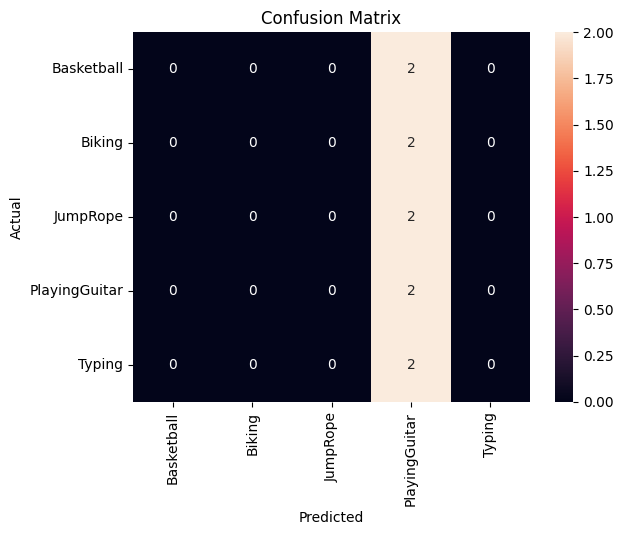

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on test data
y_pred = np.argmax(model.predict(X_test), axis=1)

# Print classification report
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
